## Python statistics essential training - 05_04_crossvalidation

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Loading gapminder data for year 1985 (Live Aid!).

In [6]:
gapminder = pd.read_csv('gapminder.csv')

In [7]:
gdata = gapminder.query('year == 1985')

Refactored plotting so that it works on arbitrary datasets.

In [8]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold',
                                                   'America': 'palegreen', 'Asia': 'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)
                      
def plotfit(fit,data=gdata):
    plotdata(data)

    size, colors = sc(data)
    pp.scatter(data.age5_surviving,fit.predict(data),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

Model formulas from the last two videos

In [9]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
         '+ age5_surviving:region - age5_surviving + population')

Divide up the dataset into training and testing

In [17]:
#first mix the data
shuffled = gdata.sample(len(gdata))

In [18]:
#split the data to training and testing sets
training, testing = shuffled.iloc[:len(gdata)//2], shuffled.iloc[len(gdata)//2:]

In [19]:
# using the best model, fit the data to the training set
surviving = smf.ols(f_surviving, data=training).fit()

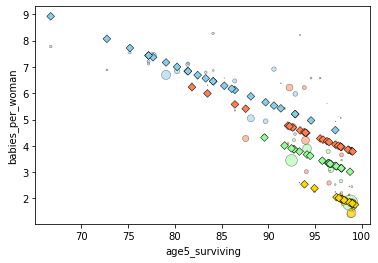

In [20]:
# observe the fit for training
plotfit(surviving,training)

In [14]:
# mean squared error for training set
surviving.mse_resid

1.052704441745709

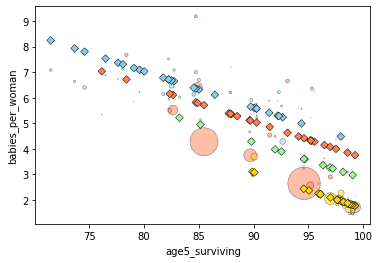

In [22]:
# observe the fit for testing, different points but fit is comprable
plotfit(surviving,testing)

In [23]:
# to get mse, start with model prediction 
resid = surviving.predict(testing) - testing.babies_per_woman
# find the degrees of freedom
df = len(testing) - surviving.df_model - 1
#square and sum variables -df
np.sum(resid**2) / df
# in test data, mse is comprable

0.9678419241172467

In [25]:
# repeate training and testing to get an average mse
def cross_validate(data,formula,response,n=100):
    ret = []
    
    for i in range(n):
        shuffled = data.sample(len(data))
        
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        
        trained = smf.ols(formula, data=training).fit()
        
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2) / df
        
        ret.append(mse)
    
    return np.mean(ret)

In [26]:
# try on simplest model
cross_validate(gdata,f_groupmeans,'babies_per_woman')

1.6456454117093053

In [27]:
# try on our best model, note mse value
cross_validate(gdata,f_surviving,'babies_per_woman')

1.0562645375647273

In [28]:
# try on most complex model
cross_validate(gdata,f_srp,'babies_per_woman')

1.2554580315882256